Team Number: 4  

Group Members:
1. BRENDAN EDWARD RAJ,  
2. CHUA ZONG HAN LIONEL,  
3. JASBIR KAUR,  
4. KOH YAO HAO,  
5. TIANG SOON LONG,  
6. TOH ZHEN WEI

---







# Section 1: Introduction

## 1.1 Problem Statement:

Accurately predicting football match outcomes has long been a challenge for analysts, bettors, and sports fans. Traditional prediction models rely on expert opinions, statistical trends, and historical performance, but these methods often fail to capture the complexity and dynamic nature of the game.

This project aims to explore the various machine learning models that predict football match outcomes based on historical match data, team statistics, and other relevant factors. By utilising modeling techniques, the objective is to enhance forecasting reliability and offer useful insights for analysts, teams, and even fans of the game.  



---



### 1.2 About the Dataset:
#### 1.2.1 Dataset 1
The match data dataset contains 5,778 rows and 127 columns, representing match data from the Premier League (2017-2024).   
Each row corresponds to an individual match played by a team, including detailed match statistics, opponent information, and season-wise records.

Sample Columns in the Dataset
- Match Details: Date, Round, Day, Season
- Team Performance: Venue, Result (W/D/L), Goals For, Goals Against, Opponent
- Possession & Passing: Possession %, Passes Attempted, Passes Completed, Progressive Passes
- Shooting & Goals: Shots, Shots on Target, Expected Goals (xG), Goals
- Defensive Actions: Tackles, Interceptions, Blocks, Clearances
- Dribbling & Carrying: Successful Take-Ons, Carries into Final Third, Progressive Carries

---

#### 1.2.2 Dataset 2
The FIFA Team Rating Dataset is sourced from the FIFA video game series, which assigns numerical ratings to teams based on their in-game squad attributes. These ratings are influenced by real-world player performances and are regularly updated by EA Sports through squad updates. These updates reflect player transfers, form changes, ensuring that the ratings stay aligned with real-world football dynamics. This indirectly helps us quantify areas of football that are hard to be represented as values.

The dataset includes several important attributes for each team:
- Overall Rating: A single score summarizing the team's overall strength.
- Attack Rating: A measure of offensive capabilities, including finishing, pace, and dribbling.
- Midfield Rating: Reflects playmaking, passing, and control in the midfield.
- Defense Rating: Evaluates defensive organization, tackling, and positioning.



---


URL Links to Data Sources:
1. https://sofifa.com/teams
2. https://fbref.com/en/comps/9/Premier-League-Stats

# Section 2: Project Set Up
In this section, we will import the relevant libraries and also load the scrapped data we manually collected

### 2.1 Import Libraries and Load Dataset

In [3]:
from datetime import timedelta

import time
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [4]:
df = pd.read_csv("2017-2024 match data.csv")

In [5]:
fifa_game_team_rating_df= pd.read_csv("fifa_team_rating.csv")

# Section 3: Data Cleaning
In this section, we will conduct data cleaning and explore our data.

### 3.1 Fix Mismatched Team and Opponent Names

From the website we scrapped our data from, we realised that they had given some of the teams with different names, even though it was the same 1 team.

For example:  
Brighton and Hove Albion vs Brighton  
Manchester United vs Manchester Utd


We will correct the names so that the data is standardised and every team only has one name.

In [6]:
team_names = set(df["Team"].unique())
opponent_names = set(df["Opponent"].unique())

only_in_team = sorted(team_names - opponent_names)
only_in_opponent = sorted(opponent_names - team_names)

print("Names in 'Team' but not in 'Opponent':", only_in_team)
print("Names in 'Opponent' but not in 'Team':", only_in_opponent)

Names in 'Team' but not in 'Opponent': ['Brighton and Hove Albion', 'Huddersfield Town', 'Manchester United', 'Newcastle United', 'Nottingham Forest', 'Sheffield United', 'Tottenham Hotspur', 'West Bromwich Albion', 'West Ham United', 'Wolverhampton Wanderers']
Names in 'Opponent' but not in 'Team': ['Brighton', 'Huddersfield', 'Manchester Utd', 'Newcastle Utd', "Nott'ham Forest", 'Sheffield Utd', 'Tottenham', 'West Brom', 'West Ham', 'Wolves']


In [7]:
team_name_corrections = {
    "Brighton and Hove Albion": "Brighton",
    "Huddersfield Town": "Huddersfield",
    "Manchester United": "Manchester Utd",
    "Newcastle United": "Newcastle Utd",
    "Nottingham Forest": "Nott'ham Forest",
    "Sheffield United": "Sheffield Utd",
    "Tottenham Hotspur": "Tottenham",
    "West Bromwich Albion": "West Brom",
    "West Ham United": "West Ham",
    "Wolverhampton Wanderers": "Wolves",
}

df["Team"] = df["Team"].replace(team_name_corrections)

### 3.2 Checking for Missing Data

In [8]:
print(df.isnull().sum()[df.isnull().sum() > 0])

Attendance    882
SoT%            3
G/Sh            3
G/SoT         184
Dist            3
npxG/Sh         3
Save%         169
dtype: int64


### 3.3 Handling Missing Data for SoT%, G/Sh, Dist and npxG/sh
Next, we investigate the data to understand why there are exactly 3 records missing for the following categories:

1. SoT% (Shots on Target %) = Percentage of shots that are on target  
2. G/Sh = Goals per shot taken  
3. Dist = Average Shot Distance  
4. npxG/sh = Non-Penalty Expected Goals per shot

Upon analysing the data and why there were missing values, we are confident that the website we scrapped the data from had mistakenly left it blank instead of '0.0'.   

How we realised this:

As the team had taken 0 shots, it would be impossible to have SoT% (Shots on Target %) or G/SoT (Goals per Shot on Target) - you can't produce any shot related metrics if a team doesn't take any shots

Thus, we will update the missing values in SoT%, G/Sh, Dist and npxG/Sh with 0

In [9]:
df['SoT%'] = df['SoT%'].fillna(0.0)
df['G/Sh'] = df['G/Sh'].fillna(0.0)
df['Dist'] = df['Dist'].fillna(0.0)
df['npxG/Sh'] = df['npxG/Sh'].fillna(0.0)

### 3.4 Handling Missing Data for Save% and G/SoT
The remaining columns of data to clean regarding missing data were: G/SoT and Save%, with 184 and 169 missing data points respectively.  

Similar to the previous step, we realised that the website we scrapped the data from had mistakenly left G/SoT and Save% blank.

Fixes Made for Save%:  
1. Ensure Save% is 0.0 when no shots were faced  
2. Compute Save% when SoTA > 0

Fixes Made for G/SoT:
1. G/SoT = 0.0 when SoT == 0 (No shots on target → No goals from shots on target)

In [10]:
df.loc[(df['SoTA'] == 0) & (df['Saves'] == 0), 'Save%'] = 0.0
df.loc[df['Save%'].isnull() & (df['SoTA'] > 0), 'Save%'] = (df['Saves'] / df['SoTA']) * 100
df.loc[df['SoT'] == 0, 'G/SoT'] = 0.0

### 3.5 Handling Missing Data for Attendance
Attendance has 882 missing datapoints, which makes up about 15% of our dataset.

Upon analysis and some research,  
2020-2021 Premier League season, many games had no attendance due to COVID-19 restrictions  
The no-fan period in the Premier League due to COVID-19 was mainly from:  
March 2020 – May 2021 (End of 2019-20 season & full 2020-21 season)  

First, we will check if there is any missing attendance outside covid period

In [11]:
# Convert Date column to DateTime
df["Date"] = pd.to_datetime(df["Date"])

covid_start = pd.to_datetime("2020-03-01")
covid_end = pd.to_datetime("2021-05-31")

df[df['Attendance'].isnull() & ~((df['Date'] >= covid_start) & (df['Date'] <= covid_end))]

,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,...,Progressive Carrying Distance,Progressive Carries,Carries into Final Third,Carries into Penalty Area,Miscontrols,Dispossessed,Passes Received,Progressive Passes Rec,Season,Team
4027,2023-05-28,16:30,Premier League,Matchweek 38,Sun,Away,L,1.0,2.0,Aston Villa,...,818.0,19.0,6.0,9.0,18.0,9.0,365.0,33.0,2022-2023,Brighton
4065,2023-05-28,16:30,Premier League,Matchweek 38,Sun,Home,W,2.0,1.0,Brighton,...,766.0,20.0,18.0,5.0,13.0,9.0,226.0,26.0,2022-2023,Aston Villa


From our code, we realised that there is 1 match with missing attendance data (2 records related to the same match)  
We will update attendance for missing attendance for Aston Villa vs Brighton using another reliable data source

Source: https://www.skysports.com/football/aston-villa-vs-brighton-and-hove-albion/stats/465006#:~:text=Aston%20Villa%20vs%20Brighton%20and,Villa%20ParkAttendance%3A%2042%2C212

In [12]:
df.loc[[4027, 4065], 'Attendance'] = 42212

For the remaining data which is still missing (covid games), we will replace the missing attendance with the team's median for that dataset  
We chose to use the median instead of setting it to 0 as it would mislead the machine learning model to identify false patterns and introduce bias in predictions.

In [13]:
# Step 1: Compute median attendance for each team when playing at home
home_medians = df[df['Venue'] == 'Home'].groupby('Team')['Attendance'].median()

# Step 2: Fill missing attendance for home games using their own home median
df.loc[(df['Attendance'].isnull()) & (df['Venue'] == 'Home'), 'Attendance'] = df['Team'].map(home_medians)

# Step 3: Fill remaining missing attendance for away games using the opponent's median (opponent is the home team)
df.loc[(df['Attendance'].isnull()) & (df['Venue'] == 'Away'), 'Attendance'] = df['Opponent'].map(home_medians)

We do a final check if there are any missing data remaining in the dataset. Empty output meaning no missing data in the dataset left.

In [14]:
print(df.isnull().sum()[df.isnull().sum() > 0])

Series([], dtype: int64)


In [15]:
# Dropping columns which has no direct impact with outcome
df = df.drop(columns=['Captain', 'Formation', 'Opp Formation', 'Referee',"Time", "Day", "Comp", "Attendance"])

# Move 'Season' to index 4
cols = list(df.columns)
cols.insert(4, cols.pop(cols.index('Season')))
df = df[cols]

# Move 'Team' to the index 7
cols = list(df.columns)
cols.insert(7, cols.pop(cols.index('Team')))
df = df[cols]

### 3.6 FIFA Video Game Team Rating Dataset Cleaning

In [16]:
fifa_game_team_rating_df = fifa_game_team_rating_df[['Roster Date', 'Team Name', 'Overall Rating', 'Attack', 'Midfield', 'Defense']]
fifa_game_team_rating_df.head()

,Roster Date,Team Name,Overall Rating,Attack,Midfield,Defense
0,12/3/2025,Manchester City,85,85,85,83
1,12/3/2025,Liverpool,84,84,83,86
2,12/3/2025,Arsenal,83,81,85,81
3,12/3/2025,Aston Villa,81,82,80,80
4,12/3/2025,Chelsea,81,83,82,79


Cleaning the dataset by fixing mismatched team names, as team names will be the primary variable used to merge both datasets together

In [17]:
team_names = set(df["Team"].unique())
fifa_names = set(fifa_game_team_rating_df["Team Name"].unique())

only_in_team = sorted(team_names - fifa_names)
only_in_fifa = sorted(fifa_names - team_names)

print("Names in 'Team' but not in 'Fifa':", only_in_team)
print("Names in 'Fifa' but not in 'Team':", only_in_fifa)

Names in 'Team' but not in 'Fifa': ['Bournemouth', 'Brighton', 'Fulham', 'Huddersfield', 'Manchester Utd', 'Newcastle Utd', "Nott'ham Forest", 'Sheffield Utd', 'Tottenham', 'West Brom', 'West Ham', 'Wolves']
Names in 'Fifa' but not in 'Team': ['AFC Bournemouth', 'Brighton & Hove Albion', 'Fulham FC', 'Huddersfield Town', 'Hull City', 'Manchester United', 'Middlesbrough', 'Newcastle United', 'Nottingham Forest', 'Sheffield United', 'Sunderland', 'Tottenham Hotspur', 'West Bromwich Albion', 'West Ham United', 'Wolverhampton Wanderers']


In [18]:
fifa_team_name_corrections = {
    "AFC Bournemouth": "Bournemouth",
    "Brighton & Hove Albion": "Brighton",
    "Fulham FC": "Fulham",
    "Huddersfield Town": "Huddersfield",
    "Manchester United": "Manchester Utd",
    "Newcastle United": "Newcastle Utd",
    "Nottingham Forest": "Nott'ham Forest",
    "Sheffield United": "Sheffield Utd",
    "Tottenham Hotspur": "Tottenham",
    "West Bromwich Albion": "West Brom",
    "West Ham United": "West Ham",
    "Wolverhampton Wanderers": "Wolves",
}

fifa_game_team_rating_df["Team Name"] = fifa_game_team_rating_df["Team Name"].replace(fifa_team_name_corrections)

<ipython-input-18-1cd026c0b80d>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fifa_game_team_rating_df["Team Name"] = fifa_game_team_rating_df["Team Name"].replace(fifa_team_name_corrections)


# Section 4: Exploratory Data Analysis (EDA)

### 4.1 Goal Distribution

Most matches have low goal counts, with 0, 1, or 2 goals being the most frequent.  
The distribution is right-skewed, meaning high-scoring matches are rare.

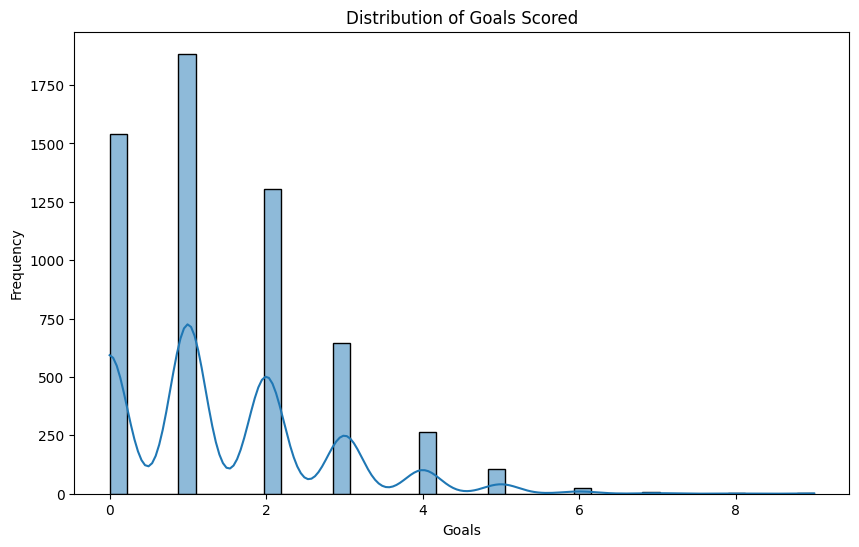

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(df['GF'], kde=True)
plt.title('Distribution of Goals Scored')
plt.xlabel('Goals')
plt.ylabel('Frequency')
plt.show()

### 4.2 Match Result Distribution  
In this dataset there is much more wins/losses than draws.  
Thus predicting draws may be harder.

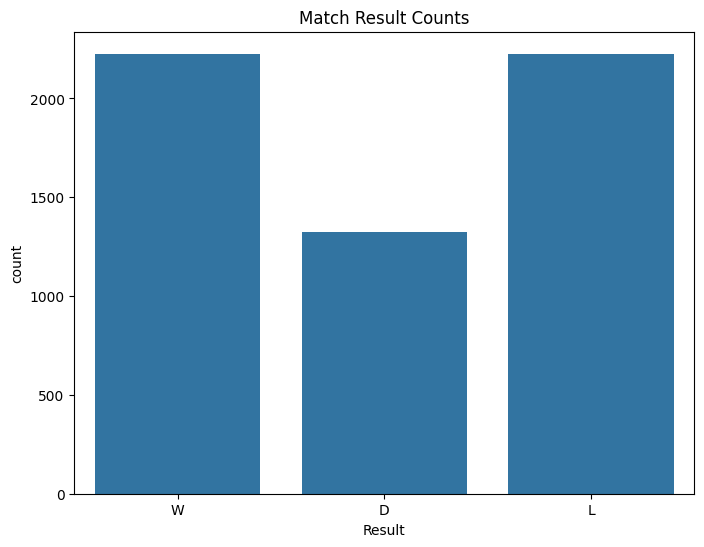

In [20]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Result', data=df)
plt.title('Match Result Counts')
plt.show()

### 4.3 Home vs. Away Performance:

Teams tend to perform better at home, with higher win counts compared to away games.  
Away matches have a higher frequency of losses, reinforcing the home advantage effect in football.

<Axes: xlabel='Venue', ylabel='count'>

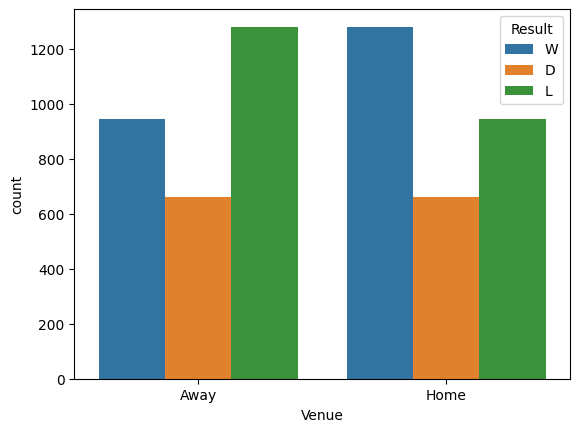

In [21]:
sns.countplot(x="Venue", hue="Result", data=df)

### 4.4 Feature Correlation

In machine learning, feature correlation analysis helps identify redundant or highly related variables to improve model efficiency and prevent overfitting.

When two features are 100% correlated, keeping both adds no additional value, so they can be removed.

Similarly, features with very high correlation (but not identical) often represent similar types of data, making one redundant (e.g., `"Live-ball Passes"` vs. `"Passes Received"`).

Additionally, domain knowledge plays a crucial role in feature selection, as some variables may have little to no impact on predicting football match outcomes (e.g., `"Throw-ins Taken"` and `"Corner Kick Types"`).

By systematically removing highly correlated and irrelevant features, the dataset is refined to include only unique and meaningful predictors, improving model interpretability and performance.

In [22]:
df_numeric_cols = df.select_dtypes(include=np.number).columns
corr_matrix = df[df_numeric_cols].corr()

# Identify highly correlated features
threshold = 0.9
high_corr_features = []

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            high_corr_features.append((col1, col2, corr_matrix.iloc[i, j]))

# Display highly correlated features
print("\nHighly Correlated Feature Pairs (Threshold = {}):".format(threshold))
for col1, col2, corr_value in sorted(high_corr_features, key=lambda x: -abs(x[2])):
    print(f"{col1} ⟷ {col2} | Correlation: {corr_value:.2f}")


Highly Correlated Feature Pairs (Threshold = 0.9):
Passes Attempted ⟷ Total_Att | Correlation: 1.00
Passes Completed ⟷ Total_Cmp | Correlation: 1.00
Possession % ⟷ Poss | Correlation: 1.00
Touches (Live-Ball) ⟷ Touches | Correlation: 1.00
Passes Received ⟷ Total_Cmp | Correlation: 1.00
Passes Received ⟷ Passes Completed | Correlation: 1.00
Progressive Passes Rec ⟷ PrgP | Correlation: 1.00
Live-ball Passes ⟷ Total_Att | Correlation: 1.00
Live-ball Passes ⟷ Passes Attempted | Correlation: 1.00
Short Pass Att ⟷ Short Pass Cmp | Correlation: 1.00
Medium Pass Att ⟷ Medium Pass Cmp | Correlation: 0.99
Live-ball Passes ⟷ Total_Cmp | Correlation: 0.99
Passes Completed ⟷ Live-ball Passes | Correlation: 0.99
Passes Received ⟷ Live-ball Passes | Correlation: 0.99
Touches ⟷ Total_Att | Correlation: 0.99
Touches ⟷ Passes Attempted | Correlation: 0.99
Touches (Live-Ball) ⟷ Total_Att | Correlation: 0.99
Touches (Live-Ball) ⟷ Passes Attempted | Correlation: 0.99
Touches ⟷ Live-ball Passes | Correlati

In [23]:
# Drop columns that have the another column in the df that represents the exact same kind of data (100% correlation)
df = df.drop(columns=['Total_Att', 'Total_Cmp', 'Poss', 'Touches',"Passes Received", "PrgP"])

# Drop columns that have very high correlation to other columns in the DF/ represent very similar data
df = df.drop(columns=['np:G-xG',  'Long Pass Att', 'Medium Pass Att', 'Short Pass Att','Touches (Live-Ball)','Live-ball Passes','Dead-ball Passes','Progressive Carrying Distance','Progressive Carries','GCA','Total_TotDist','Take-Ons Attempted','Passes Blocked_x','Dribblers Tackled'])

# Drop columns based on domain knowledge that these columns have no direct relation to predicting outcome of football matches
df = df.drop(columns=['Switches','Throw-ins Taken','Outswinging Corner Kicks','Inswinging Corner Kick','Straight Corner Kicks', 'SCA','SCA (Live-ball Pass)','SCA (Dead-ball Pass)', 'SCA (Take-On)', 'SCA (Shot)', 'SCA (Fouls Drawn)', 'SCA (Defensive Action)',
                     'Touches (Def Pen)',	'Touches (Def 3rd)',	'Touches (Mid 3rd)','Tackles (Att 3rd)'])


# Section 5: Data and Feature Engineering

### 5.1 Data Engineering: Merging FIFA Game Team Ratings with Match Dataset

In [24]:
# Ensure Date columns are in datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
fifa_game_team_rating_df['Roster Date'] = pd.to_datetime(fifa_game_team_rating_df['Roster Date'], format='%d/%m/%Y')

# Sort data by date (VERY IMPORTANT for merge_asof)
df = df.sort_values(by='Date')
fifa_game_team_rating_df = fifa_game_team_rating_df.sort_values(by='Roster Date')

# Merge FIFA ratings for each team (backward to ensure no future data is leaked)
df = pd.merge_asof(
    df,
    fifa_game_team_rating_df,
    left_on='Date',
    right_on='Roster Date',
    left_by='Team',  # Match Team in df with Team Name in fifa_game_team_rating_df
    right_by='Team Name',
    direction='backward'  # Ensures only past data is used
)

# Rename merged columns for the Team
df = df.rename(columns={
    'Overall Rating': 'FIFA Overall Rating',
    'Attack': 'FIFA Attack Rating',
    'Midfield': 'FIFA Midfield Rating',
    'Defense': 'FIFA Defense Rating'
})

# Merge FIFA ratings for the Opponent (backward to prevent data leakage)
df = pd.merge_asof(
    df,
    fifa_game_team_rating_df,
    left_on='Date',
    right_on='Roster Date',
    left_by='Opponent',  # Match Opponent in df with Team Name in fifa_game_team_rating_df
    right_by='Team Name',
    direction='backward'  # Ensures only past data is used
)

# Rename merged columns for the Opponent
df = df.rename(columns={
    'Overall Rating': 'Opponent FIFA Overall Rating',
    'Attack': 'Opponent FIFA Attack Rating',
    'Midfield': 'Opponent FIFA Midfield Rating',
    'Defense': 'Opponent FIFA Defense Rating'
})

# Drop unnecessary columns
df = df.drop(columns=['Roster Date_x', 'Team Name_x','Roster Date_y', 'Team Name_y'])
df.head()

,Date,Round,Venue,Result,Season,GF,GA,Team,Opponent,xG,...,Dispossessed,Progressive Passes Rec,FIFA Overall Rating,FIFA Attack Rating,FIFA Midfield Rating,FIFA Defense Rating,Opponent FIFA Overall Rating,Opponent FIFA Attack Rating,Opponent FIFA Midfield Rating,Opponent FIFA Defense Rating
0,2017-08-11,Matchweek 1,Home,W,2017-2018,4.0,3.0,Arsenal,Leicester City,2.5,...,14.0,61.0,83,81,83,82,78,79,78,76
1,2017-08-11,Matchweek 1,Away,L,2017-2018,3.0,4.0,Leicester City,Arsenal,1.5,...,12.0,16.0,78,79,78,76,83,81,83,82
2,2017-08-12,Matchweek 1,Away,W,2017-2018,2.0,0.0,Manchester City,Brighton,1.9,...,4.0,87.0,83,83,85,81,72,72,73,73
3,2017-08-12,Matchweek 1,Away,W,2017-2018,3.0,2.0,Burnley,Chelsea,0.6,...,9.0,25.0,74,74,74,76,83,86,84,81
4,2017-08-12,Matchweek 1,Away,D,2017-2018,3.0,3.0,Liverpool,Watford,2.6,...,14.0,40.0,81,82,81,81,77,78,78,76


Creating a copy of the cleaned df and assigning it as df_w_features so that it can be used for Feature Engineering

In [25]:
df_w_features= df.copy()

### 5.2 Feature: Home Advantage
Encoding home advantage as a binary variable (1 if the match is played at home, 0 otherwise).   

This feature can be useful for our classification model, as playing at home is often associated with higher chances of winning due to factors like crowd support, familiarity with the pitch, and reduced travel fatigue.

In [26]:
df_w_features['Venue_Home'] = (df_w_features['Venue'] == 'Home').astype(int)

### 5.3 Feature: Performance-Based Comparative Metrics
These features capture a team's dominance over its opponents in various aspects, such as goal difference, expected goals (xG), shots on target (SoT), and possession.

They provide insights into a team's attacking and defensive strengths. However, since they rely on match outcomes, using them directly for predictions could lead to data leakage. Instead, they will be used later on as rolling averages to reflect team trends over time without leaking future results.

In [27]:
def calculate_goal_difference(df):
    df["Goal_Diff"] = df["GF"] - df["GA"]
    return df

def calculate_xg_difference(df):
    df["xG_Difference"] = df["xG"] - df["xGA"]
    return df

def calculate_sot_difference(df):
    df["SoT_Difference"] = df["SoT"] - df["SoTA"]
    return df

def calculate_possession_difference(df):
    df["Opponent_Possession"] = 100 - df["Possession %"]
    df["Poss_Diff"] = df["Possession %"] - df["Opponent_Possession"]
    return df

### 5.4 Feature: Form-Based Features
These features quantify a team's recent performance by tracking past match results, points earned, and streaks. They include rolling average points over the last 5 matches, direct form comparisons with opponents, encoded past match sequences, and unbeaten streaks.

These metrics highlight a team's consistency and momentum, helping predict future performance trends. Since they rely on past results, they are structured to avoid data leakage by using only information available before each match.

Summary of functions:
1. `calculate_form_comparison(df)`  
  - Calculates: The difference in rolling average points (last 5 matches) between a team and its opponent.
  - Feature Value: Captures recent performance trends, helping assess which team has stronger momentum leading into the match.
2. `calculate_form_pattern(df, N=5)`
  - Calculates: A sequence of the team's last N match results (e.g., "WWLDW").
  - Feature Value: Provides historical performance context, helping detect winning/losing streaks or patterns.
  - Works with: `convert_form_pattern_to_numerical(df, N=5)` to transform categorical match sequences into numerical values.
3. `convert_form_pattern_to_numerical(df, N=5)`
  - Calculates: Converts the past N match results from `calculate_form_pattern()` into numerical values (Win = 1, Draw = 0, Loss = -1).
  - Feature Value: Transforms historical performance into a numeric format that machine learning models can interpret effectively.
4. `calculate_unbeaten_streak_before_match(df)`
  - Calculates: The number of consecutive matches a team has gone without losing before a match.
  - Feature Value: Highlights team consistency and resilience, indicating whether a team is on an unbeaten run or struggling.

5. `calculate_clean_sheet_percentage(df, N=5)`
  - Calculates: The percentage of clean sheets in the last N matches before a given match.
  - Feature Value: Captures short-term defensive consistency. Helps measure whether a team is in strong defensive form or struggling to keep clean sheets.

In [28]:
def calculate_form_comparison(df):
    df = df.sort_values(["Team", "Date"])
    df["Points_Earned"] = df["Result"].map({"W": 3, "D": 1, "L": 0})

    df["Team_Last_5_Avg_Points"] = df.groupby("Team")["Points_Earned"].shift(1).rolling(5).mean()

    # Merge with opponent's last 5 avg points
    df = df.merge(df[["Team", "Date", "Team_Last_5_Avg_Points"]],
                  left_on=["Opponent", "Date"],
                  right_on=["Team", "Date"],
                  suffixes=("", "_Opponent")).drop(columns=["Team_Opponent"], errors='ignore')

    df.rename(columns={"Team_Last_5_Avg_Points_Opponent": "Opponent_Last_5_Avg_Points"}, inplace=True)

    df["Last_5_Points_Comparison"] = df["Team_Last_5_Avg_Points"] - df["Opponent_Last_5_Avg_Points"]

    df.drop(columns=["Points_Earned"], inplace=True)

    return df

def calculate_form_pattern(df, N=5):
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(["Team", "Date"])

    form_patterns = []

    for team in df["Team"].unique():
        team_results = df[df["Team"] == team]["Result"].tolist()
        team_form = []

        for i in range(len(team_results)):
            if i == 0:
                team_form.append("")  # First match has no history
            else:
                # Extract last N results before current match
                start_idx = max(0, i - N)  # Ensure index doesn't go negative
                form_str = "".join(team_results[start_idx:i])  # Join past results into string
                team_form.append(form_str)

        form_patterns.extend(team_form)

    df["Form_Pattern_Before_Match"] = form_patterns

    return df

def convert_form_pattern_to_numerical(df, N=5):
    # Ensure column exists
    if "Form_Pattern_Before_Match" not in df.columns:
        print("Error: Form_Pattern_Before_Match column not found.")
        return df

    # Convert last N match results into separate numerical features
    for i in range(1, N+1):
        df[f"Form_{i}"] = df["Form_Pattern_Before_Match"].apply(lambda x: x[-i] if len(x) >= i else "None")

    # Map W/D/L to numerical values
    mapping = {"W": 1, "D": 0, "L": -1, "None": 0}
    for i in range(1, N+1):
        df[f"Form_{i}"] = df[f"Form_{i}"].map(mapping)

    df.drop(columns=["Form_Pattern_Before_Match"], inplace=True)

    return df

def calculate_unbeaten_streak_before_match(df):
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(["Team", "Date"])

    unbeaten_streak = []

    for team in df["Team"].unique():
        team_results = df[df["Team"] == team]["Result"].tolist()
        streak = 0
        team_streak = []

        for result in team_results:
            team_streak.append(streak)
            if result in ["W", "D"]:
                streak += 1
            else:
                streak = 0

        unbeaten_streak.extend(team_streak)

    df["Unbeaten_Streak_Before_Match"] = unbeaten_streak

    return df

def calculate_clean_sheet_percentage(df, N=5):
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(["Team", "Date"])

    df["Last_5_Clean_Sheet_Percentage"] = (
        df.groupby("Team")["CS"]
        .apply(lambda x: x.shift(1).rolling(N, min_periods=1).mean())
        .reset_index(drop=True)
    )

    return df

### 5.5 Feature: Season Performance Metrics
Understanding a team's long-term performance trends is crucial in predicting match outcomes. These features track a team's progress throughout the season by analyzing cumulative points, ranking, and comparative strength against opponents.  

By incorporating historical data, they provide insights into how consistently a team has performed and whether it is in good form or struggling. These metrics help identify title contenders, relegation risks, or mid-table teams and serve as a baseline for evaluating match expectations.

The following functions calculate seasonal performance indicators that ensure only past match data is considered, avoiding data leakage while providing useful context for predictive modeling.

Summary of functions:
1. `calculate_season_points(df)`
  - Calculates: Cumulative points earned before each match.
  - Feature Value: Represents a team's progress throughout the season.

2. `calculate_opponent_season_points(df)`
  - Calculates: The opponent’s cumulative season points before the match.
  - Feature Value: Helps compare team strength based on season-long performance.

3. `calculate_season_points_comparison(df)`
  - Calculates: The difference in season points before the match, between the team and its opponent.
  - Feature Value: Highlights the relative strength of both teams leading into the match.

4. `calculate_season_ranking(df)`
  - Calculates: Season ranking before each match, based on cumulative points.
  - Feature Value: Provides a dynamic measure of league standing and relative positioning.

5. `calculate_season_goal_difference(df)`
  - Calculates: A team's cumulative goal difference before each match in the season.
  - Feature Value: Reflects attacking and defensive efficiency over the season Also helps to assess whether a team has consistently outscored opponents or struggled defensively, and provides context on long-term performance rather than short-term fluctuations.

In [29]:
# Define a function to calculate season points earned before each match
def calculate_season_points(df):
    points_mapping = {"W": 3, "D": 1, "L": 0}

    df["Match_Points"] = df["Result"].map(points_mapping)
    df["Date"] = pd.to_datetime(df["Date"])

    df = df.sort_values(["Team", "Season", "Date"])
    df["Team_Season_Points_Before_Match"] = df.groupby(["Team", "Season"])["Match_Points"].cumsum().shift(1).fillna(0)
    df.loc[df["Round"] == "Matchweek 1", "Team_Season_Points_Before_Match"] = 0
    df.drop(columns=["Match_Points"], inplace=True)

    return df


def calculate_opponent_season_points(df):
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(["Team", "Season", "Date"])

    df = df.merge(
        df[["Team", "Season", "Date", "Team_Season_Points_Before_Match"]],
        left_on=["Opponent", "Season", "Date"],
        right_on=["Team", "Season", "Date"],
        suffixes=("", "_Opponent")
    )

    df = df.rename(columns={"Team_Season_Points_Before_Match_Opponent": "Opponent_Season_Points_Before_Match"})
    df.drop(columns=["Team_Opponent"], errors='ignore', inplace=True)

    return df

def calculate_season_points_comparison(df):
    df["Season_Points_Comparison_Before_Match"] = df["Team_Season_Points_Before_Match"] - df["Opponent_Season_Points_Before_Match"]

    return df

def calculate_season_ranking(df):
    # Rank teams based on season points before each match (lower rank = higher position)
    df["Team_Season_Rank"] = df.groupby(["Season", "Date"])["Team_Season_Points_Before_Match"].rank(ascending=False, method="min")

    df = df.merge(df[["Team", "Season", "Date", "Team_Season_Rank"]],
                  left_on=["Opponent", "Season", "Date"],
                  right_on=["Team", "Season", "Date"],
                  suffixes=("", "_Opponent")).drop(columns=["Team_Opponent"], errors='ignore')

    df.rename(columns={"Team_Season_Rank_Opponent": "Opponent_Season_Rank"}, inplace=True)
    df["Rank_Comparison"] = df["Opponent_Season_Rank"] - df["Team_Season_Rank"]

    return df

def calculate_season_goal_difference(df):
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(["Team", "Season", "Date"])

    # Compute cumulative goal difference per season for each team (before the match)
    df["Team_Goal_Difference_Before_Match"] = df.groupby(["Team", "Season"])["Goal_Diff"].cumsum().shift(1).fillna(0)

    df.loc[df["Round"] == "Matchweek 1", "Team_Goal_Difference_Before_Match"] = 0

    df = df.merge(
        df[["Team", "Season", "Date", "Team_Goal_Difference_Before_Match"]],
        left_on=["Opponent", "Season", "Date"],
        right_on=["Team", "Season", "Date"],
        suffixes=("", "_Opponent")
    )

    df.rename(columns={"Team_Goal_Difference_Before_Match_Opponent": "Opponent_Goal_Difference_Before_Match"}, inplace=True)
    df["Goal_Difference_Comparison_Before_Match"] = df["Team_Goal_Difference_Before_Match"] - df["Opponent_Goal_Difference_Before_Match"]
    df.drop(columns=["Team_Opponent"], errors='ignore', inplace=True)

    return df

### 5.6 Feature: Venue-Based Performance Trends
`calculate_home_away_performance(df, N=5)` measures how a team performs differently at home vs. away.

  - Calculates: Rolling average points per match at home vs. away.
  - Feature Value: Highlights a team's home advantage or away struggles.

Includes:
- `Home_Points_Per_Match` → Average points earned at home over last N games.
- `Away_Points_Per_Match` → Average points earned away over last N games.
- `Home_Away_Performance_Diff` → Difference between home & away performance.
- `Venue_Adjusted_Points_Per_Match` → Expected points based on venue.

In [30]:
def calculate_home_away_performance(df, N=5):
    df = df.sort_values(["Team", "Date"])
    df["Points_Earned"] = df["Result"].map({"W": 3, "D": 1, "L": 0})

    df["Home_Points_Earned"] = np.where(df["Venue"] == "Home", df["Points_Earned"], np.nan)
    df["Away_Points_Earned"] = np.where(df["Venue"] == "Away", df["Points_Earned"], np.nan)

    df["Home_Points_Per_Match"] = (
      df.groupby("Team")["Home_Points_Earned"]
      .transform(lambda x: x.shift(1).rolling(N, min_periods=1).mean())
      .ffill()
      )

    df["Away_Points_Per_Match"] = (
        df.groupby("Team")["Away_Points_Earned"]
        .transform(lambda x: x.shift(1).rolling(N, min_periods=1).mean())
        .ffill()
    )

    df["Home_Away_Performance_Diff"] = df["Home_Points_Per_Match"] - df["Away_Points_Per_Match"]

    df["Venue_Adjusted_Points_Per_Match"] = np.where(
        df["Venue"] == "Home",
        df["Home_Points_Per_Match"],
        df["Away_Points_Per_Match"]
    )

    return df

### 5.7 Feature: Head-to-Head Performance Metrics
In football, past encounters between two teams can be a strong indicator of future match outcomes. Some teams consistently outperform others due to tactical advantages, psychological factors, or historical dominance. The Head-to-Head (H2H) Performance Metrics capture these trends by analyzing the most recent encounters between two teams. This information helps identify patterns such as a team having a winning streak over a specific opponent, a history of closely contested matches, or frequent draws.


`calculate_head_to_head_record(df, N=4)`
  - Calculates:
    - The number of wins, draws, and losses in the last N matches between two teams.
    - The total number of H2H matches played before the current game.
    - The win percentage against the opponent over the last N encounters.
  - Feature Value:
Identifies historical dominance or weakness against a specific opponent.
Highlights whether a team is on a winning streak or struggling in recent H2H meetings.

In [31]:
def calculate_head_to_head_record(df, N=4):
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(["Date"])

    # Create a copy of the dataframe to hold the results
    result_df = df.copy()

    # Initialize H2H columns
    result_df["H2H_Wins"] = 0
    result_df["H2H_Draws"] = 0
    result_df["H2H_Losses"] = 0
    result_df["H2H_Total_Matches"] = 0
    result_df["H2H_Win_Percentage"] = 0.0

    # Process each match
    for idx, current_match in result_df.iterrows():
        team = current_match["Team"]
        opponent = current_match["Opponent"]
        match_date = current_match["Date"]

        historical_matches = df[
            (df["Date"] < match_date) &
            (df["Team"] == team) &
            (df["Opponent"] == opponent)
        ]

        last_n_matches = historical_matches.tail(N)

        if not last_n_matches.empty:
            h2h_wins = last_n_matches[last_n_matches["Result"] == "W"].shape[0]
            h2h_draws = last_n_matches[last_n_matches["Result"] == "D"].shape[0]
            h2h_losses = last_n_matches[last_n_matches["Result"] == "L"].shape[0]

            h2h_total = h2h_wins + h2h_draws + h2h_losses
            h2h_win_pct = h2h_wins / h2h_total if h2h_total > 0 else 0.0

            result_df.at[idx, "H2H_Wins"] = h2h_wins
            result_df.at[idx, "H2H_Draws"] = h2h_draws
            result_df.at[idx, "H2H_Losses"] = h2h_losses
            result_df.at[idx, "H2H_Total_Matches"] = h2h_total
            result_df.at[idx, "H2H_Win_Percentage"] = h2h_win_pct

    return result_df

### 5.8 Feature: FIFA Game Ratings
The FIFA Game Ratings feature leverages team ratings from the FIFA video game series, which assigns numerical ratings to teams based on their in-game attributes. These ratings reflect real-world player performances, team balance, and squad depth.

This feature extracts rating differences between a team and its opponent, highlighting disparities in overall squad strength, attacking power, midfield control, and defensive solidity. By incorporating these differences, models can assess whether a team has a significant advantage or disadvantage in key areas of the pitch.

`calculate_fifa_rating_diffs(df)`
- Calculates:
  - The overall rating difference between the team and its opponent.
  - The attack rating difference, which measures the disparity in offensive strength.
  - The midfield rating difference, reflecting control in playmaking and ball distribution.
  - The defense rating difference, indicating variations in defensive capabilities.
- Feature Value:
The FIFA rating differences quantify team strength disparities and serve as a predictive indicator of match outcomes. Higher positive values suggest a stronger team relative to its opponent, while negative values indicate a weaker squad.

In [32]:
def create_fifa_features(df):
    # Overall, Attack, Midfield, and Defense rating differences
    df['FIFA Overall Rating Diff'] = df['FIFA Overall Rating'] - df['Opponent FIFA Overall Rating']
    df['FIFA Attack Rating Diff'] = df['FIFA Attack Rating'] - df['Opponent FIFA Attack Rating']
    df['FIFA Midfield Rating Diff'] = df['FIFA Midfield Rating'] - df['Opponent FIFA Midfield Rating']
    df['FIFA Defense Rating Diff'] = df['FIFA Defense Rating'] - df['Opponent FIFA Defense Rating']

    return df

Apply functions of the features we engineered into the dataframe, and encoding the Target Variable ( the `Result` column) for Classification. This is necessary because most ML models only work with numerical data.

In [33]:
# Apply functions
df_w_features = calculate_goal_difference(df_w_features)
df_w_features = calculate_xg_difference(df_w_features)
df_w_features = calculate_sot_difference(df_w_features)
df_w_features = calculate_possession_difference(df_w_features)
df_w_features = calculate_form_comparison(df_w_features)
df_w_features = calculate_form_pattern(df_w_features)
df_w_features = convert_form_pattern_to_numerical(df_w_features)
df_w_features = calculate_unbeaten_streak_before_match(df_w_features)
df_w_features = calculate_season_points(df_w_features)
df_w_features = calculate_opponent_season_points(df_w_features)
df_w_features = calculate_season_points_comparison(df_w_features)
df_w_features = calculate_season_goal_difference(df_w_features)
df_w_features = calculate_head_to_head_record(df_w_features)
df_w_features = calculate_clean_sheet_percentage(df_w_features)
df_w_features = calculate_season_ranking(df_w_features)
df_w_features = calculate_home_away_performance(df_w_features)
df_w_features = create_fifa_features(df_w_features)

# Encode Target Variable
le = LabelEncoder()
df_w_features['Result'] = le.fit_transform(df_w_features['Result'])

df_w_features.tail()

,Date,Round,Venue,Result,Season,GF,GA,Team,Opponent,xG,...,Home_Points_Earned,Away_Points_Earned,Home_Points_Per_Match,Away_Points_Per_Match,Home_Away_Performance_Diff,Venue_Adjusted_Points_Per_Match,FIFA Overall Rating Diff,FIFA Attack Rating Diff,FIFA Midfield Rating Diff,FIFA Defense Rating Diff
5773,2024-12-29,Matchweek 19,Away,0,2024-2025,2.0,2.0,Wolves,Tottenham,0.7,...,NaN,1.0,1.5,1.000000,0.500000,1.000000,-4,-5,-5,-2
5774,2025-01-06,Matchweek 20,Home,1,2024-2025,0.0,3.0,Wolves,Nott'ham Forest,1.5,...,0.0,NaN,1.5,1.333333,0.166667,1.500000,0,-1,-1,-1
5775,2025-01-15,Matchweek 21,Away,1,2024-2025,0.0,3.0,Wolves,Newcastle Utd,1.6,...,NaN,0.0,1.0,2.000000,-1.000000,2.000000,-4,-3,-8,-3
5776,2025-01-20,Matchweek 22,Away,1,2024-2025,1.0,3.0,Wolves,Chelsea,0.8,...,NaN,0.0,1.5,1.333333,0.166667,1.333333,-5,-4,-6,-3
5777,2025-01-25,Matchweek 23,Home,1,2024-2025,0.0,1.0,Wolves,Arsenal,0.7,...,0.0,NaN,1.5,0.333333,1.166667,1.500000,-8,-3,-9,-7


## 5.9 Feature: Calculating the Rolling Averages of in game statistics.
Selecting numeric features from `df_w_features` to apply rolling averages, as rolling averages can’t be applied to categorical/text features.  

The second line of code removes certain features from the rolling averages calculation.
Features like `"Result"`, `"Venue_Home"`, and "`H2H_Wins"` are excluded because:
- Some are categorical (e.g., `"Result"`, `"Venue_Home"`).
- Others are already rolling averages (e.g., `"Last_5_Avg_Points"`).
- Some are pre-calculated metrics that don’t require further smoothing (e.g., `"Rank_Comparsion"`).

Rolling averages help smooth out variations and prevent data leakage by ensuring that only historical data is used for predictions.

In [34]:
# Select numeric columns only as rolling averages can only be done on numeric columns
df_w_features_numeric_cols = df_w_features.select_dtypes(include=np.number).columns

# Specify the features that will have the rolling average function applied to them by dropping the features that do not need rolling averages
rolling_features = df_w_features_numeric_cols.drop(['Result', 'Venue_Home', 'FIFA Overall Rating', 'FIFA Attack Rating','FIFA Midfield Rating', 'FIFA Defense Rating', 'Opponent FIFA Overall Rating','Opponent FIFA Attack Rating','Opponent FIFA Midfield Rating','Opponent FIFA Defense Rating',
                                                    "FIFA Overall Rating Diff", "FIFA Attack Rating Diff", "FIFA Midfield Rating Diff", "FIFA Defense Rating Diff",
                                                    'Team_Last_5_Avg_Points',	'Opponent_Last_5_Avg_Points',	'Last_5_Points_Comparison', 'Form_1', 'Form_2', 'Form_3', 'Form_4', 'Form_5', 'Unbeaten_Streak_Before_Match',	'Team_Season_Points_Before_Match',	'Opponent_Season_Points_Before_Match',
                                                    'Season_Points_Comparison_Before_Match',	'Team_Goal_Difference_Before_Match',	'Opponent_Goal_Difference_Before_Match',	'Goal_Difference_Comparison_Before_Match',	'H2H_Wins',	'H2H_Draws',
                                                    'H2H_Losses',	'H2H_Total_Matches',	'H2H_Win_Percentage',	'Last_5_Clean_Sheet_Percentage',	'Team_Season_Rank',	'Opponent_Season_Rank',	'Rank_Comparison', 'Points_Earned',	'Home_Points_Earned',
                                                    'Away_Points_Earned',	'Home_Points_Per_Match',	'Away_Points_Per_Match',	'Home_Away_Performance_Diff',	'Venue_Adjusted_Points_Per_Match'], errors='ignore')

In [35]:
def rolling_averages(group, cols, new_cols):
    group = group.sort_values("Date")
    rolling_stats = group[cols].rolling(5, closed='left').mean()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    return group

In [36]:
# Use the previously specified columns (rolling_features) to have Rolling Average function applied and set a standard name format for the new columns created
cols = list(rolling_features)
new_cols = [f"{c}_Rolling_Avg" for c in cols]

In [37]:
# Apply Rolling Average Function
df_w_rolling_features = df_w_features.groupby("Team").apply(lambda x: rolling_averages(x, cols, new_cols))
df_w_rolling_features = df_w_rolling_features.droplevel('Team')

# Reset Index
df_w_rolling_features.index = range(df_w_rolling_features.shape[0])

# Drop all rows with NaN for Last_5_Avg_Points_Opponent, due to newly promoted teams with no history
df_w_rolling_features = df_w_rolling_features.dropna(subset=["Opponent_Last_5_Avg_Points"]).reset_index(drop=True)

# Create DF to specify columns that we are not allowed to use, to prevent data leakage
invalid_cols = df_w_features.columns[1:83].tolist()

# Keep 'Result' (index 3)
invalid_cols = [col for col in invalid_cols if col not in [df_w_features.columns[3]]]

#
invalid_cols.extend([df_w_features.columns[92],df_w_features.columns[93],df_w_features.columns[94],df_w_features.columns[95],df_w_features.columns[96],df_w_features.columns[121],df_w_features.columns[122],df_w_features.columns[123]])

# Drop the invalid columns
df_w_rolling_features = df_w_rolling_features.drop(columns=invalid_cols, axis=1)

pd.set_option("display.max_columns", None)
df_w_rolling_features.head(10)

<ipython-input-37-988410a42257>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_w_rolling_features = df_w_features.groupby("Team").apply(lambda x: rolling_averages(x, cols, new_cols))


,Date,Result,FIFA Overall Rating,FIFA Attack Rating,FIFA Midfield Rating,FIFA Defense Rating,Opponent FIFA Overall Rating,Opponent FIFA Attack Rating,Opponent FIFA Midfield Rating,Opponent FIFA Defense Rating,Venue_Home,Team_Last_5_Avg_Points,Opponent_Last_5_Avg_Points,Last_5_Points_Comparison,Form_1,Form_2,Form_3,Form_4,Form_5,Unbeaten_Streak_Before_Match,Team_Season_Points_Before_Match,Opponent_Season_Points_Before_Match,Season_Points_Comparison_Before_Match,Team_Goal_Difference_Before_Match,Opponent_Goal_Difference_Before_Match,Goal_Difference_Comparison_Before_Match,H2H_Wins,H2H_Draws,H2H_Losses,H2H_Total_Matches,H2H_Win_Percentage,Last_5_Clean_Sheet_Percentage,Team_Season_Rank,Opponent_Season_Rank,Rank_Comparison,Home_Points_Per_Match,Away_Points_Per_Match,Home_Away_Performance_Diff,Venue_Adjusted_Points_Per_Match,FIFA Overall Rating Diff,FIFA Attack Rating Diff,FIFA Midfield Rating Diff,FIFA Defense Rating Diff,GF_Rolling_Avg,GA_Rolling_Avg,xG_Rolling_Avg,xGA_Rolling_Avg,Sh_Rolling_Avg,SoT_Rolling_Avg,SoT%_Rolling_Avg,G/Sh_Rolling_Avg,G/SoT_Rolling_Avg,Dist_Rolling_Avg,FK_Rolling_Avg,PK_Rolling_Avg,PKatt_Rolling_Avg,npxG_Rolling_Avg,npxG/Sh_Rolling_Avg,G-xG_Rolling_Avg,SoTA_Rolling_Avg,Saves_Rolling_Avg,Save%_Rolling_Avg,CS_Rolling_Avg,Total_Cmp%_Rolling_Avg,Total_PrgDist_Rolling_Avg,Short Pass Cmp_Rolling_Avg,Short Pass Cmp%_Rolling_Avg,Medium Pass Cmp_Rolling_Avg,Medium Pass Cmp%_Rolling_Avg,Long Pass Cmp_Rolling_Avg,Long Pass Cmp%_Rolling_Avg,Ast_Rolling_Avg,xAG_Rolling_Avg,xA_Rolling_Avg,KP_Rolling_Avg,1/3_Rolling_Avg,PPA_Rolling_Avg,CrsPA_Rolling_Avg,Passes Attempted_Rolling_Avg,Passes from Free Kicks_Rolling_Avg,Through Balls_Rolling_Avg,Crosses_Rolling_Avg,Corner Kicks_Rolling_Avg,Passes Completed_Rolling_Avg,Passes Offside_Rolling_Avg,GCA (Live-ball Pass)_Rolling_Avg,GCA (Dead-ball Pass)_Rolling_Avg,GCA (Take-On)_Rolling_Avg,GCA (Shot)_Rolling_Avg,GCA (Fouls Drawn)_Rolling_Avg,GCA (Defensive Action)_Rolling_Avg,Tackles_Rolling_Avg,Tackles Won_Rolling_Avg,Tackles (Def 3rd)_Rolling_Avg,Tackles (Mid 3rd)_Rolling_Avg,Dribbles Challenged_Rolling_Avg,% of Dribblers Tackled_Rolling_Avg,Challenges Lost_Rolling_Avg,Blocks _Rolling_Avg,Shots Blocked_Rolling_Avg,Passes Blocked_y_Rolling_Avg,Interceptions_Rolling_Avg,Tkl+Int_Rolling_Avg,Clearances_Rolling_Avg,Errors_Rolling_Avg,Possession %_Rolling_Avg,Touches (Att 3rd)_Rolling_Avg,Touches (Att Pen)_Rolling_Avg,Successful Take-Ons _Rolling_Avg,Successful Take-On %_Rolling_Avg,Times Tackled During Take-On_Rolling_Avg,Tackled During Take-On Percentage_Rolling_Avg,Carries _Rolling_Avg,Total Carrying Distance_Rolling_Avg,Carries into Final Third_Rolling_Avg,Carries into Penalty Area_Rolling_Avg,Miscontrols_Rolling_Avg,Dispossessed_Rolling_Avg,Progressive Passes Rec_Rolling_Avg,Goal_Diff_Rolling_Avg,xG_Difference_Rolling_Avg,SoT_Difference_Rolling_Avg,Opponent_Possession_Rolling_Avg,Poss_Diff_Rolling_Avg
0,2017-09-25,2,83,86,82,81,77,80,77,76,1,1.4,1.6,-0.2,0,1,-1,-1,1,2,7.0,8.0,-1.0,-1.0,0.0,-1.0,0,0,0,0,0.0,0.4,2.0,1.0,-1.0,3.0,0.333333,2.666667,3.0,6,6,5,5,1.4,1.6,1.64,1.34,16.2,5.4,28.28,0.066,0.146,17.50,0.2,0.0,0.0,1.64,0.104,-0.24,4.6,3.0,67.00,0.4,81.30,3081.6,248.2,88.06,220.8,87.26,42.8,55.36,1.4,1.42,1.18,13.4,40.8,13.0,2.4,644.6,11.2,3.2,14.2,6.4,526.2,3.8,1.8,0.2,0.0,0.4,0.0,0.2,17.2,13.2,7.6,7.6,16.0,40.42,9.6,7.2,2.2,5.0,14.4,31.6,22.8,0.8,60.6,202.6,25.0,11.0,70.78,4.2,29.24,472.6,2411.4,21.4,5.0,13.2,11.6,55.4,-0.2,0.30,0.8,39.4,21.2
1,2017-10-01,2,83,86,82,81,74,75,74,73,1,1.4,1.4,0.0,1,0,1,-1,-1,3,10.0,7.0,3.0,1.0,-2.0,3.0,0,0,0,0,0.0,0.6,2.0,5.0,3.0,3.0,0.333333,2.666667,3.0,9,11,8,8,1.0,1.0,1.58,1.22,13.8,4.4,27.54,0.050,0.106,17.38,0.8,0.2,0.2,1.42,0.102,-0.58,4.4,3.4,87.00,0.6,81.82,3118.8,242.8,88.24,227.8,87.24,40.8,55.54,0.6,1.08,1.12,10.2,39.6,12.0,1.8,640.4,10.8,3.6,13.8,6.0,526.2,2.8,1.0,0.0,0.0,0.2,0.2,0.2,15.6,11.6,6.4,6.8,15.6,32.38,10.6,7.0,2.6,4.4,14.2,29.8,21.2,0.8,60.8,201.8,24.8,10.4,67.62,4.8,32.40,476.8,2335.2,19.8,5.2,15.4,10.8,55.8,0.0,0.3

In [38]:
# This line creates a separate copy of df_w_rolling_features, which will be used specifically for model building.
# Avoids Modifying the Original Processed Data
# Allows Quick Resets for Experimentation in model building, can rerun this cell to reset it. No need to recompute rolling averages—saves time.

df_model_building_all_features = df_w_rolling_features.copy()

# Section 6: Decision Tree Model Building

Import Necessary Libraries for Decision Tree Classification

In [39]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import graphviz
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE


### 6.1 Date Preprocessing

In this section, we preprocess the date column and split the dataset into training, development (validation), and test sets to ensure proper model evaluation.

Steps involved:


* Convert Date Column to Datetime Format
* Split Data into Train, Development, and Test Sets
* Drop Unnecessary Columns
* Define Features (X) and Target Variable (y)

This preprocessing ensures the dataset is structured correctly for model training, validation, and testing while preventing data leakage.


In [40]:
# Convert date column to datetime
df_model_building_all_features['Date'] = pd.to_datetime(df_model_building_all_features['Date'])
df_model_building_all_features['year'] = df_model_building_all_features['Date'].dt.year

# Splitting data
train = df_model_building_all_features[df_model_building_all_features["Date"] < '2023-01-01']
dev = df_model_building_all_features[(df_model_building_all_features["Date"] >= '2023-01-01') &
                                     (df_model_building_all_features["Date"] < '2024-01-01')]
test = df_model_building_all_features[df_model_building_all_features["Date"] >= '2024-01-01']

# Drop unneeded columns
train, dev, test = train.drop(['Date', 'year'], axis=1), dev.drop(['Date', 'year'], axis=1), test.drop(['Date', 'year'], axis=1)

# Define features (X) and target variable (y)
X_train, y_train = train.drop('Result', axis=1), train['Result']
X_dev, y_dev = dev.drop('Result', axis=1), dev['Result']
X_test, y_test = test.drop('Result', axis=1), test['Result']


## 6.2 Baseline Model (No Modifications)

In this section, we establish a baseline model using a Decision Tree Classifier to assess initial performance before applying any modifications or optimizations.



Baseline Model Accuracy on Dev Set: 0.3931

Classification Report (Dev Set):
               precision    recall  f1-score   support

           0       0.19      0.24      0.21       170
           1       0.47      0.46      0.46       322
           2       0.45      0.41      0.43       322

    accuracy                           0.39       814
   macro avg       0.37      0.37      0.37       814
weighted avg       0.40      0.39      0.40       814



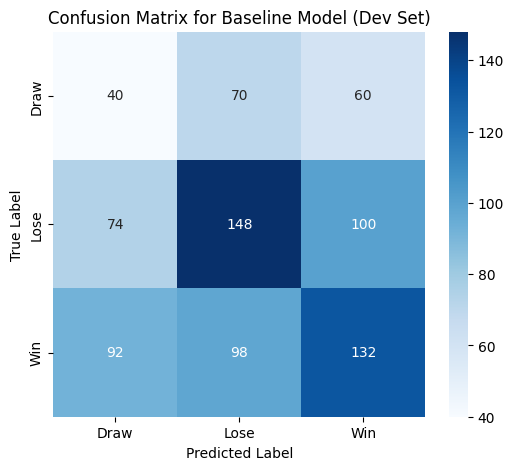

In [39]:
# ✅ Train Baseline Model
baseline_model = DecisionTreeClassifier(random_state=42)
baseline_model.fit(X_train, y_train)

# ✅ Predict on Dev Set
y_dev_pred = baseline_model.predict(X_dev)

# ✅ Compute Accuracy
baseline_dev_acc = accuracy_score(y_dev, y_dev_pred)

# ✅ Print Classification Report
print(f"Baseline Model Accuracy on Dev Set: {baseline_dev_acc:.4f}")
print("\nClassification Report (Dev Set):\n", classification_report(y_dev, y_dev_pred))

# ✅ Generate & Plot Confusion Matrix
cm_baseline = confusion_matrix(y_dev, y_dev_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm_baseline, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Draw","Lose","Win"],
            yticklabels=["Draw","Lose","Win"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Baseline Model (Dev Set)")
plt.show()


**Results**:

Baseline Model Accuracy on Dev Set: **39.31%**

This indicates that the model's overall correctness is around 39.31%, which is relatively low.

**Classification Report Analysis**:

The precision, recall, and F1-score for each class suggest that the model struggles with making accurate predictions.
The class with the highest performance is class "Win", with an F1-score of 0.43, but it still lacks strong accuracy.
The macro average and weighted average F1-score are around 0.39-0.40, showing overall poor model performance.

**Confusion Matrix Insights:**

The confusion matrix visually represents misclassifications, indicating that the model might be biased toward certain predictions or failing to distinguish between different classes effectively.


**Key Takeaways**:

The baseline Decision Tree model exhibits low accuracy, implying that it requires further tuning, feature engineering, or a more sophisticated model to improve performance.

We will explore in the following pages on how to increase the model's accuracy using different methods such as Hyperparameter tuning (e.g., adjusting tree depth, pruning) and Feature Selection.

## 6.3 Model Variations (All tested on Dev Set First)

### 6.3.1 Gini vs. Entropy

In this section, we compare two different criteria for training a Decision Tree Classifier: Gini Impurity and Entropy. The goal is to determine which criterion results in better performance on the development dataset.

In [40]:
# Train Decision Tree using Gini Impurity
gini_model = DecisionTreeClassifier(criterion='gini', random_state=42)
gini_model.fit(X_train, y_train)

# Train Decision Tree using Entropy
entropy_model = DecisionTreeClassifier(criterion='entropy', random_state=42)
entropy_model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

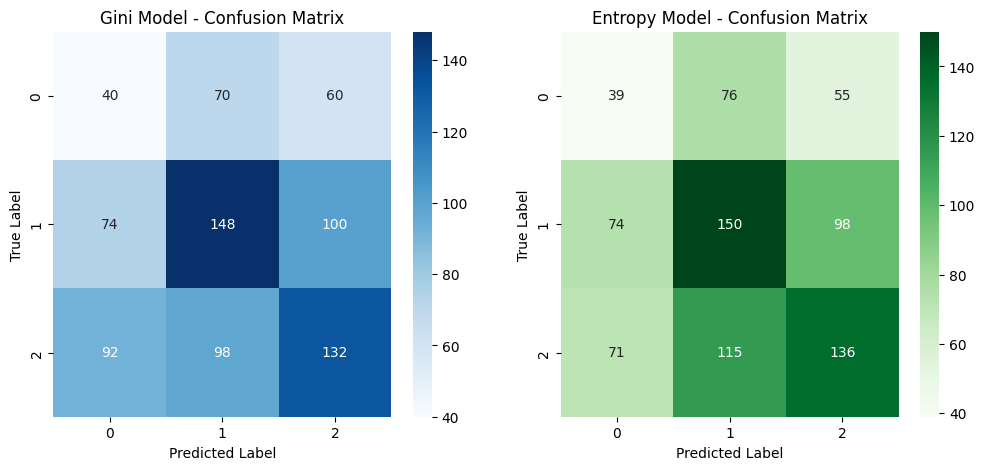

In [41]:
# ✅ Predict on Dev Set for Both Models
y_dev_pred_gini = gini_model.predict(X_dev)
y_dev_pred_entropy = entropy_model.predict(X_dev)

# ✅ Generate Confusion Matrices
cm_gini = confusion_matrix(y_dev, y_dev_pred_gini)
cm_entropy = confusion_matrix(y_dev, y_dev_pred_entropy)

# ✅ Plot Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Gini Confusion Matrix
sns.heatmap(cm_gini, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Gini Model - Confusion Matrix")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# Entropy Confusion Matrix
sns.heatmap(cm_entropy, annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("Entropy Model - Confusion Matrix")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.show()


In [42]:
# ✅ Compute Accuracy for Both Models
gini_accuracy = accuracy_score(y_dev, y_dev_pred_gini)
entropy_accuracy = accuracy_score(y_dev, y_dev_pred_entropy)

print(f"Gini Model Accuracy: {gini_accuracy:.4f}")
print(f"Entropy Model Accuracy: {entropy_accuracy:.4f}")

# ✅ Generate Classification Reports
print("\nClassification Report for Gini Model:")
print(classification_report(y_dev, y_dev_pred_gini))

print("\nClassification Report for Entropy Model:")
print(classification_report(y_dev, y_dev_pred_entropy))

Gini Model Accuracy: 0.3931
Entropy Model Accuracy: 0.3993

Classification Report for Gini Model:
              precision    recall  f1-score   support

           0       0.19      0.24      0.21       170
           1       0.47      0.46      0.46       322
           2       0.45      0.41      0.43       322

    accuracy                           0.39       814
   macro avg       0.37      0.37      0.37       814
weighted avg       0.40      0.39      0.40       814


Classification Report for Entropy Model:
              precision    recall  f1-score   support

           0       0.21      0.23      0.22       170
           1       0.44      0.47      0.45       322
           2       0.47      0.42      0.45       322

    accuracy                           0.40       814
   macro avg       0.37      0.37      0.37       814
weighted avg       0.40      0.40      0.40       814



**Results:**
* Gini Model Accuracy: 39.31%
* Entropy Model Accuracy: 39.93%

The accuracy difference is minimal, suggesting that both criteria result in similar overall performance.


**Classification Report Analysis:**

The models perform similarly across all three classes

**Confusion Matrix Insights**
* The Gini Model tends to predict class "Lose" (2) more frequently than the Entropy Model.
* The Entropy Model distributes predictions more evenly across all three classes.

**Misclassification Patterns:**
* Both models frequently misclassify "Draw" (0) as "Win" (1).
* The Entropy model makes slightly fewer misclassification errors for "Lose" (2).

**Key Takeaways:**

Accuracy is nearly the same for both models (~39-40%), meaning neither criterion provides a significant advantage in this case.

The Entropy-based Decision Tree shows a slight improvement in classification metrics.

Further improvements are needed, such as:
Feature engineering to provide more meaningful inputs.
Hyperparameter tuning (e.g., max depth, min samples split).

### 6.3.2 Recursive Feature Elimination (RFE)

In this section, we implement Recursive Feature Elimination (RFE) to improve model performance by selecting the most relevant features.

**Key Benefits of RFE:**
* Feature Selection: Helps remove irrelevant or redundant features that may negatively impact model performance.
* Reduced Overfitting: By limiting the number of input variables, RFE can lead to better generalization.
* Improved Interpretability: Having fewer features makes the model easier to understand and analyze.

In [43]:
# Recursive Feature Elimination (RFE)
rfe = RFE(DecisionTreeClassifier(random_state=42), n_features_to_select=10)
rfe.fit(X_train, y_train)
selected_features = X_train.columns[rfe.support_]

# Train model on selected features
X_train_rfe, X_dev_rfe = X_train[selected_features], X_dev[selected_features]
rfe_model = DecisionTreeClassifier(random_state=42)
rfe_model.fit(X_train_rfe, y_train)

DecisionTreeClassifier(random_state=42)

RFE Accuracy on Dev Set: 0.4177


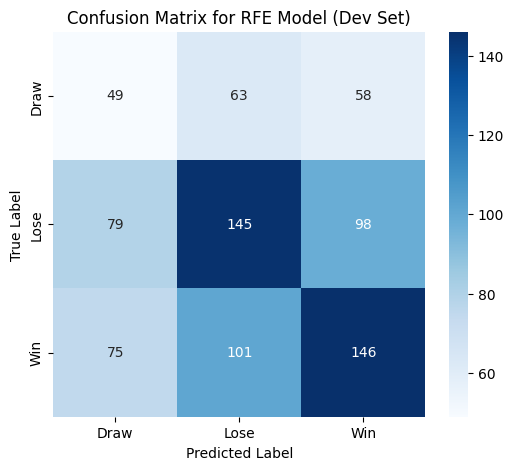


📊 Classification Report for RFE Model:
              precision    recall  f1-score   support

           0       0.24      0.29      0.26       170
           1       0.47      0.45      0.46       322
           2       0.48      0.45      0.47       322

    accuracy                           0.42       814
   macro avg       0.40      0.40      0.40       814
weighted avg       0.43      0.42      0.42       814



In [44]:
# ✅ Predict on Dev Set for RFE Model
y_dev_pred_rfe = rfe_model.predict(X_dev_rfe)

# Evaluate on dev set
rfe_dev_acc = accuracy_score(y_dev, rfe_model.predict(X_dev_rfe))
print(f"RFE Accuracy on Dev Set: {rfe_dev_acc:.4f}")

# ✅ Generate Confusion Matrix
cm_rfe = confusion_matrix(y_dev, y_dev_pred_rfe)

# ✅ Plot Confusion Matrix for RFE Model
plt.figure(figsize=(6,5))
sns.heatmap(cm_rfe, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Draw","Lose","Win"],
            yticklabels=["Draw","Lose","Win"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for RFE Model (Dev Set)")
plt.show()

from sklearn.metrics import classification_report

print("\n📊 Classification Report for RFE Model:")
print(classification_report(y_dev, y_dev_pred_rfe))

**Results:**

RFE Model Accuracy: **39.80%**

**Classification Report Insights:**

Overall, RFE did not significantly boost performance but helped slightly improve recall for "Draw" (0).

**Confusion Matrix Observations:**
* Better balance in Draw (0) predictions, though misclassifications still occur frequently.
* True positives for Win (1) are similar to previous models, with some minor differences.
* The model continues to struggle distinguishing between "Lose" (2) and "Win" (1).

**Key Takeaways:**

Minimal improvement in accuracy suggests that all features were equally relevant, meaning feature selection may not be the key limitation.

### 6.3.3 Hyperparameter Tuning - GridSearchCV

In this section, we apply GridSearchCV to fine-tune the hyperparameters of the Decision Tree model to improve performance.

**Hyperparameter Tuning Process**

GridSearchCV is used to optimize the following hyperparameters:

* max_depth: {3, 5, 10, None} → Limits tree depth to prevent overfitting.
* min_samples_split: {2, 5, 10} → Minimum samples needed to split a node.
* min_samples_leaf: {1, 3, 5} → Minimum samples required at a leaf node.
* criterion: {‘gini’, ‘entropy’} → Splitting strategy.
* A 5-fold cross-validation (cv=5) is performed to select the best model based on accuracy.

In [45]:
# Define hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'criterion': ['gini', 'entropy']
}

# Perform GridSearchCV on the dev set
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get best model
best_tuned_model = grid_search.best_estimator_
best_tuned_acc = accuracy_score(y_dev, best_tuned_model.predict(X_dev))

print(f"Best Tuned Model Accuracy on Dev Set: {best_tuned_acc:.4f}")
print(f"Best Parameters: {grid_search.best_params_}")

Best Tuned Model Accuracy on Dev Set: 0.5184
Best Parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


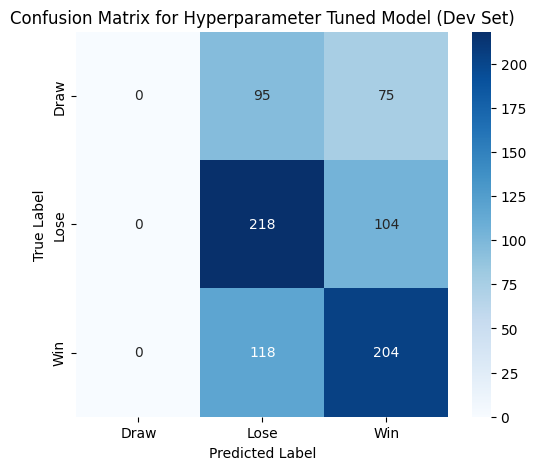


📊 Classification Report for Best Tuned Model:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       170
           1       0.51      0.68      0.58       322
           2       0.53      0.63      0.58       322

    accuracy                           0.52       814
   macro avg       0.35      0.44      0.39       814
weighted avg       0.41      0.52      0.46       814



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [46]:
# ✅ Predict on Dev Set for Best-Tuned Model
y_dev_pred_tuned = best_tuned_model.predict(X_dev)

# ✅ Generate Confusion Matrix
cm_tuned = confusion_matrix(y_dev, y_dev_pred_tuned)

# ✅ Plot Confusion Matrix for Tuned Model
plt.figure(figsize=(6,5))
sns.heatmap(cm_tuned, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Draw","Lose","Win"],
            yticklabels=["Draw","Lose","Win"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Hyperparameter Tuned Model (Dev Set)")
plt.show()

from sklearn.metrics import classification_report

print("\n📊 Classification Report for Best Tuned Model:")
print(classification_report(y_dev, y_dev_pred_tuned))


**Results:**

Best Tuned Accuracy (Dev Set): **51.84%**

Best Parameters Found:
{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}

* Entropy-based decision tree performed best.
* A relatively shallow tree (max_depth=3) was optimal, suggesting that deeper trees led to overfitting.
* Lower min_samples_split=2 and min_samples_leaf=1 allow for more granularity in decision-making.

**Confusion Matrix Analysis**

Improvements:

* The model significantly reduced misclassification errors compared to previous models.
* Higher true positives for "Win" and "Lose" classes, as seen in the darker squares.

Drawbacks:

* The model failed to classify any instances of "Draw" (0) correctly.
* Heavy misclassification of "Draw" into "Win" suggests that the model struggles to differentiate "Draw" from other categories.

**Classification Report Insights:**
* Major improvement in "Win" (1) and "Lose" (2) class predictions
* Draw" (0) Class is completely ignored
* Precision, Recall, and F1-score are 0.00, meaning the model never predicts "Draw".
* This suggests a data imbalance issue or a need for different features to capture "Draw" better.

**Key Takeaways:**
* Accuracy improved significantly from ~39% to 51.84%
* "Win" and "Lose" class predictions improved
* "Draw" class is completely misclassified
* Address the "Draw" class issue by trying class balancing techniques



### 6.3.4 Class Weight Balancing

In this section, we address the issue of class imbalance by applying class weight balancing to the Decision Tree model.

We use the best hyperparameters from GridSearchCV and we will introduce
**class_weight='balanced'**.

This automatically adjusts class weights inversely proportional to class frequencies, ensuring that underrepresented classes have a stronger influence.

In [47]:
# ✅ Train the model with balanced class weights
balanced_model = DecisionTreeClassifier(
    criterion='entropy',  # Using best criterion from tuning
    max_depth=3,  # Using best depth from tuning
    min_samples_leaf=1,  # Using best min_samples_leaf from tuning
    min_samples_split=2,  # Using best min_samples_split from tuning
    class_weight="balanced",  # ✅ Balances class weights automatically
    random_state=42
)

# ✅ Train on Train Set
balanced_model.fit(X_train, y_train)

# ✅ Predict on Dev Set
y_dev_pred_balanced = balanced_model.predict(X_dev)


✅ Balanced Model Accuracy on Dev Set: 0.4435


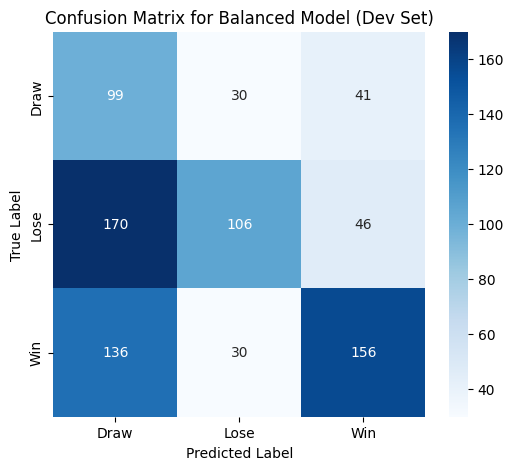


📊 Classification Report for Balanced Model:
              precision    recall  f1-score   support

           0       0.24      0.58      0.34       170
           1       0.64      0.33      0.43       322
           2       0.64      0.48      0.55       322

    accuracy                           0.44       814
   macro avg       0.51      0.47      0.44       814
weighted avg       0.56      0.44      0.46       814



In [48]:
# ✅ Compute Accuracy for Balanced Model
balanced_dev_acc = accuracy_score(y_dev, y_dev_pred_balanced)

# ✅ Print Accuracy
print(f"\n✅ Balanced Model Accuracy on Dev Set: {balanced_dev_acc:.4f}")

# ✅ Generate Confusion Matrix for Balanced Model
cm_balanced = confusion_matrix(y_dev, y_dev_pred_balanced)

# ✅ Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm_balanced, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Draw","Lose","Win"],
            yticklabels=["Draw","Lose","Win"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Balanced Model (Dev Set)")
plt.show()

from sklearn.metrics import classification_report

print("\n📊 Classification Report for Balanced Model:")
print(classification_report(y_dev, y_dev_pred_balanced))

**Results:**

Balanced Model Accuracy (Dev Set): **44.35%**

**Confusion Matrix Insights:**

The model now recognizes the "Draw" class (0) significantly better than the untuned model.

**Classification Report Analysis:**
* Significant Recall Boost for "Draw" (0): Jumped from 0.00 to 0.58.
* F1-scores are now more balanced across classes.
* Macro avg and weighted avg improved, suggesting a better overall class distribution.

**Key Takeaways:**
* Now correctly predicts "Draw" class, solving a major issue from the previous model.
* Improved overall class balance, reducing bias towards "Win" and "Lose".
* Trade-off between fairness and accuracy—the model now generalizes better across classes at the expense of peak performance.


### 6.3.5 AutoML (TPOT)

In this section, we implement TPOT (Tree-based Pipeline Optimization Tool), an AutoML framework that automates:

* Model selection
* Hyperparameter tuning
* Feature preprocessing
* Pipeline optimization

TPOT leverages genetic algorithms to find the best ML pipeline for a given dataset.

TPOT Installation & Setup

The installation process requires specific package versions due to compatibility issues.

Necessary steps include:
* Uninstalling and reinstalling Scikit-learn (<1.3.0)
* Ensuring dependencies (NumPy, SciPy, Pandas, Joblib) are up to date.
* Restarting the session for proper package integration.

Once installed, TPOT is successfully imported.

In [ ]:
!pip uninstall -y tpot scikit-learn


In [ ]:
!pip install tpot "scikit-learn<1.3.0"

In [ ]:
!pip install -U numpy scipy pandas joblib tqdm stopit update_checker

In [ ]:
!pip uninstall -y scipy numpy scikit-learn tpot
!pip install numpy==1.23.5 scipy==1.10.1 scikit-learn==1.2.2 tpot

In [ ]:
from tpot import TPOTClassifier
print("TPOT is successfully installed!")

Running TPOT AutoML

TPOTClassifier is initialized with:

* generations=5: The number of iterations to optimize the model.
* population_size=20: The number of models evaluated per generation.
* verbosity=2: Enables tracking of optimization progress.
* random_state=42: Ensures reproducibility.
* n_jobs=-1: Utilizes all CPU cores for parallel computation.

The model is trained on (X_train, y_train).

Best pipeline selection is automated based on the development set performance.



In [42]:
from tpot import TPOTClassifier
from tpot.config import classifier_config_dict

In [43]:
# Run TPOT AutoML
tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2, random_state=42, n_jobs=-1)
tpot.fit(X_train, y_train)

# Evaluate on Dev Set
tpot_dev_acc = accuracy_score(y_dev, tpot.predict(X_dev))
print(f"TPOT AutoML Accuracy on Dev Set: {tpot_dev_acc:.4f}")


Version 0.12.1 of tpot is outdated. Version 1.0.0 was released Wednesday February 26, 2025.


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.5271828378666014

Generation 2 - Current best internal CV score: 0.5345458239539729

Generation 3 - Current best internal CV score: 0.5345458239539729

Generation 4 - Current best internal CV score: 0.5345458239539729

Generation 5 - Current best internal CV score: 0.5373422171195635

Best pipeline: GradientBoostingClassifier(LinearSVC(Binarizer(input_matrix, threshold=0.25), C=0.0001, dual=True, loss=squared_hinge, penalty=l2, tol=0.01), learning_rate=0.001, max_depth=1, max_features=0.7500000000000001, min_samples_leaf=1, min_samples_split=4, n_estimators=100, subsample=0.7500000000000001)
TPOT AutoML Accuracy on Dev Set: 0.5369


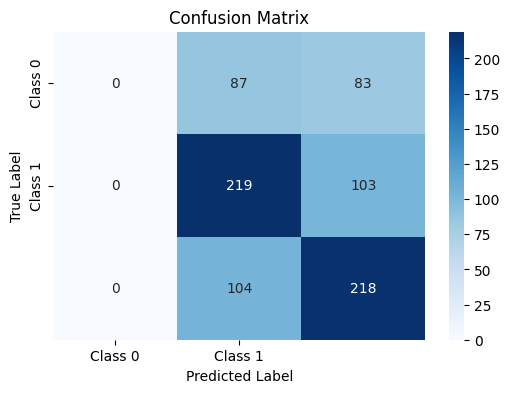

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       170
           1       0.53      0.68      0.60       322
           2       0.54      0.68      0.60       322

    accuracy                           0.54       814
   macro avg       0.36      0.45      0.40       814
weighted avg       0.42      0.54      0.47       814



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
# Predict on Dev Set
y_pred = tpot.predict(X_dev)

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_dev, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
print("Classification Report:\n", classification_report(y_dev, y_pred))


In [45]:
# ✅ Extract the best model selected by TPOT
best_tpot_model = tpot.fitted_pipeline_

# ✅ Print the model to see what TPOT chose
print("\n🚀 Best Model Selected by TPOT:\n", best_tpot_model)



🚀 Best Model Selected by TPOT:
 Pipeline(steps=[('binarizer', Binarizer(threshold=0.25)),
                ('stackingestimator',
                 StackingEstimator(estimator=LinearSVC(C=0.0001,
                                                       random_state=42,
                                                       tol=0.01))),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=1,
                                            max_features=0.7500000000000001,
                                            min_samples_split=4,
                                            random_state=42,
                                            subsample=0.7500000000000001))])


**Results:**

TPOT AutoML Accuracy on Dev Set: **53.69%**

After running TPOT AutoML, we obtained the best-performing model pipeline along with its accuracy.

Best pipeline: **GradientBoostingClassifier**(LinearSVC(Binarizer(input_matrix, threshold=0.25)))

* Gradient Boosting Classifier: An ensemble learning method that builds trees sequentially, optimizing for performance.
* Linear SVC (Support Vector Classifier): A linear classification model, likely used for feature transformation.
* Binarizer (threshold=0.25): A preprocessing step to convert numerical features into binary values.

**TPOT Training Progress:**
* Model performance gradually improved as TPOT iterated through generations.
* Final CV Score (53.73%) aligns with dev set accuracy (53.69%), indicating stable optimization.

**Classification Report Analysis:**
* Class 0 (Draws) Misclassification Issue
* Class 0 is ignored → The model never predicts Draws correctly.
* Try SMOTE again, focusing on generating more samples for Class 0.

**Key Takeaways:**
* Best model found is an ensemble-based approach (Gradient Boosting)
* TPOT’s model outperforms manually tuned Decision Trees
* Automated feature preprocessing (Binarization, SVC) improves learning
* Cross-validation consistency suggests reliable performance


### 6.3.6 AutoML (TPOT+SMOTE)

This section of your Jupyter Notebook is focused on AutoML (TPOT) with SMOTE to oversample the minority class.

SMOTE (Synthetic Minority Over-sampling Technique) generates synthetic samples for underrepresented classes to help the model learn better.


In [ ]:
!pip uninstall -y scikit-learn imbalanced-learn
!pip install --no-cache-dir scikit-learn==1.2.2 imbalanced-learn



In [ ]:
from imblearn.over_sampling import SMOTE
print("SMOTE imported successfully!")


In [43]:
# ✅ Apply SMOTE to create more Draw examples
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("SMOTE applied successfully!")

# ✅ Train TPOT on the balanced dataset
tpot = TPOTClassifier(
    generations=5,        # Number of iterations TPOT runs
    population_size=20,   # Number of models per generation
    verbosity=2,          # Show progress
    random_state=42,
    n_jobs=-1             # Use all CPU cores
)

tpot.fit(X_train_resampled, y_train_resampled)  # ✅ Train on resampled data


SMOTE applied successfully!


Version 0.12.1 of tpot is outdated. Version 1.0.0 was released Wednesday February 26, 2025.


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.511183891140845

Generation 2 - Current best internal CV score: 0.516884648037211

Generation 3 - Current best internal CV score: 0.5271770037426313

Generation 4 - Current best internal CV score: 0.5302320909710515

Generation 5 - Current best internal CV score: 0.5326362234099795

Best pipeline: ExtraTreesClassifier(OneHotEncoder(BernoulliNB(BernoulliNB(input_matrix, alpha=0.001, fit_prior=False), alpha=100.0, fit_prior=False), minimum_fraction=0.2, sparse=False, threshold=10), bootstrap=True, criterion=entropy, max_features=0.8, min_samples_leaf=19, min_samples_split=5, n_estimators=100)


TPOTClassifier(generations=5, n_jobs=-1, population_size=20, random_state=42,
               verbosity=2)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliNB was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliNB was fitted with feature names
  warnings.warn(



✅ TPOT AutoML (With SMOTE) Accuracy on Test Set: 0.5135


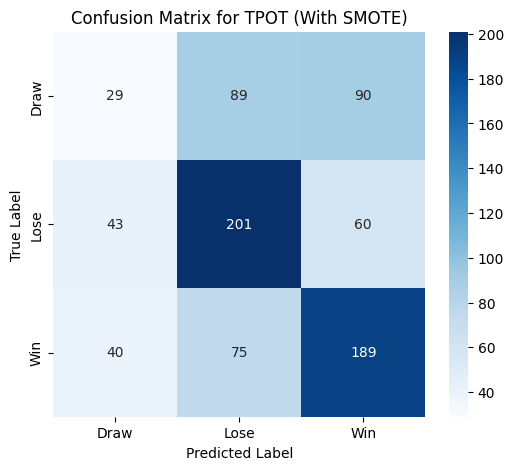


📊 Classification Report for TPOT (With SMOTE):
              precision    recall  f1-score   support

           0       0.26      0.14      0.18       208
           1       0.55      0.66      0.60       304
           2       0.56      0.62      0.59       304

    accuracy                           0.51       816
   macro avg       0.46      0.47      0.46       816
weighted avg       0.48      0.51      0.49       816



In [44]:
# ✅ Predict on Test Set
y_test_pred_smote = tpot.predict(X_test)

# ✅ Compute Accuracy
tpot_smote_acc = accuracy_score(y_test, y_test_pred_smote)

# ✅ Print Accuracy
print(f"\n✅ TPOT AutoML (With SMOTE) Accuracy on Test Set: {tpot_smote_acc:.4f}")

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Compute Confusion Matrix
cm_smote = confusion_matrix(y_test, y_test_pred_smote)

# ✅ Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm_smote, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Draw","Lose","Win"],
            yticklabels=["Draw","Lose","Win"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for TPOT (With SMOTE)")
plt.show()

from sklearn.metrics import classification_report

# ✅ Print Classification Report
print("\n📊 Classification Report for TPOT (With SMOTE):")
print(classification_report(y_test, y_test_pred_smote))

In [45]:
# ✅ Extract the Best Model Found by TPOT
best_tpot_model = tpot.fitted_pipeline_

# ✅ Print Best Model
print("\n🚀 Best Model Selected by TPOT:\n", best_tpot_model)


🚀 Best Model Selected by TPOT:
 Pipeline(steps=[('stackingestimator-1',
                 StackingEstimator(estimator=BernoulliNB(alpha=0.001,
                                                         fit_prior=False))),
                ('stackingestimator-2',
                 StackingEstimator(estimator=BernoulliNB(alpha=100.0,
                                                         fit_prior=False))),
                ('onehotencoder',
                 OneHotEncoder(minimum_fraction=0.2, sparse=False)),
                ('extratreesclassifier',
                 ExtraTreesClassifier(bootstrap=True, criterion='entropy',
                                      max_features=0.8, min_samples_leaf=19,
                                      min_samples_split=5, random_state=42))])


**Results:**

* Test Accuracy: **51.35%**
* While accuracy is comparable to the other TPOT models, it is slightly lower than the default TPOT (53.69%).
* The accuracy is still an improvement over traditional Decision Trees, which ranged from 39.31% to 44.35%.

**Confusion Matrix Insights:**
* The model still struggles to classify Draws (Class 0), even with SMOTE applied.
* Predictions for Wins are more stable, though misclassification still exists.
* The model has a balanced ability to classify Losses.



### 6.3.7 AutoML (TPOT, Forced DT)

In this section, we force TPOT to use only tree-based models by restricting the search space to Decision Tree-based algorithms using the config_dict parameter.

**Why Restrict TPOT to Decision Trees?**
* Default TPOT selection included Gradient Boosting + LinearSVC, meaning it did not choose a pure Decision Tree.
* To compare tree-only performance, we force TPOT to explore only tree-based models

In [46]:
# ✅ Create a TPOT Config that Only Uses Decision Trees
tree_config = {
    'sklearn.tree.DecisionTreeClassifier': classifier_config_dict['sklearn.tree.DecisionTreeClassifier']
}

# ✅ Run TPOT with Only Decision Trees Allowed
tpot = TPOTClassifier(
    generations=5,
    population_size=20,
    verbosity=2,
    random_state=42,
    config_dict=tree_config,  # 🔥 Force TPOT to use only decision trees
    n_jobs=-1
)

# ✅ Train TPOT
tpot.fit(X_train, y_train)

Version 0.12.1 of tpot is outdated. Version 1.0.0 was released Wednesday February 26, 2025.


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.5198127567902271

Generation 2 - Current best internal CV score: 0.5198127567902271

Generation 3 - Current best internal CV score: 0.5198127567902271

Generation 4 - Current best internal CV score: 0.5198127567902271

Generation 5 - Current best internal CV score: 0.5203194035049246

Best pipeline: DecisionTreeClassifier(CombineDFs(input_matrix, DecisionTreeClassifier(input_matrix, criterion=entropy, max_depth=4, min_samples_leaf=15, min_samples_split=20)), criterion=entropy, max_depth=3, min_samples_leaf=17, min_samples_split=9)


TPOTClassifier(config_dict={'sklearn.tree.DecisionTreeClassifier': {'criterion': ['gini',
                                                                                  'entropy'],
                                                                    'max_depth': range(1, 11),
                                                                    'min_samples_leaf': range(1, 21),
                                                                    'min_samples_split': range(2, 21)}},
               generations=5, n_jobs=-1, population_size=20, random_state=42,
               verbosity=2)

In [47]:
# ✅ Extract the Best Model Found by TPOT
best_tpot_model = tpot.fitted_pipeline_

# ✅ Print Best Model
print("\n🚀 Best Model Selected by TPOT:\n", best_tpot_model)


🚀 Best Model Selected by TPOT:
 Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('functiontransformer',
                                                 FunctionTransformer(func=<function copy at 0x7e3845b3d9e0>)),
                                                ('stackingestimator',
                                                 StackingEstimator(estimator=DecisionTreeClassifier(criterion='entropy',
                                                                                                    max_depth=4,
                                                                                                    min_samples_leaf=15,
                                                                                                    min_samples_split=20,
                                                                                                    random_state=42)))])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifie

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(



✅ TPOT Decision Tree Accuracy on Dev Set: 0.5319


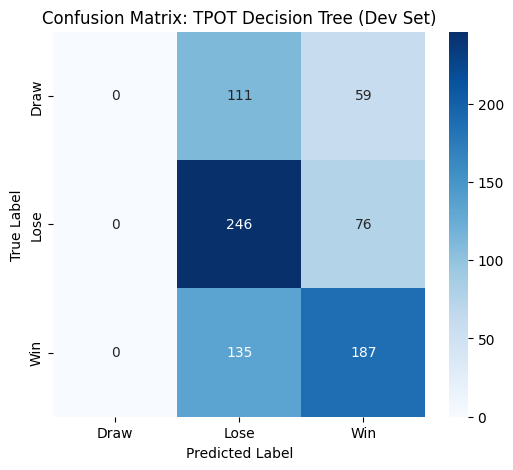


📊 Classification Report for TPOT Decision Tree (Dev Set):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       170
           1       0.50      0.76      0.60       322
           2       0.58      0.58      0.58       322

    accuracy                           0.53       814
   macro avg       0.36      0.45      0.40       814
weighted avg       0.43      0.53      0.47       814



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
# ✅ Predict on Dev Set
y_dev_pred = tpot.predict(X_dev)

# ✅ Compute Accuracy on Dev Set
tpot_dt_dev_accuracy = accuracy_score(y_dev, y_dev_pred)
print(f"\n✅ TPOT Decision Tree Accuracy on Dev Set: {tpot_dt_dev_accuracy:.4f}")

# ✅ Generate Confusion Matrix for Dev Set
cm_tpot_dt_dev = confusion_matrix(y_dev, y_dev_pred)

# ✅ Plot Confusion Matrix for Dev Set
plt.figure(figsize=(6,5))
sns.heatmap(cm_tpot_dt_dev, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Draw","Lose","Win"],
            yticklabels=["Draw","Lose","Win"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix: TPOT Decision Tree (Dev Set)")
plt.show()

# ✅ Print Classification Report for Dev Set
print("\n📊 Classification Report for TPOT Decision Tree (Dev Set):")
print(classification_report(y_dev, y_dev_pred))

**Results:**
* TPOT Decision Tree Accuracy (Dev Set): 53.19%
* This is very close to the unrestricted TPOT model (53.69%).

**Confusion Matrix Insights:**
* Improvements over previous models
* "Draw" (0) is still not predicted correctly at all (0% recall).
* Model is biased towards "Win" and "Lose", completely ignoring "Draw".

**Classification Report Analysis:**
* Accuracy improved significantly from baseline models (~39%).
* The model learns "Win" and "Lose" classes well.
* "Draw" is completely ignored.
* Bias towards predicting "Win" → Model may overfit to this class.

**Key Takeaways:**
* TPOT’s Decision Tree is almost as good as its best unrestricted model (53.19% vs. 53.69%).
* Tree-based models perform well when tuned properly.
* The "Draw" class is still problematic, meaning feature engineering or data balancing is needed.

## 6.4 Model Comparison Analysis

When choosing the best model for the test set, accuracy is an important factor, but not the only one. Other key considerations include class balance, misclassification issues, and overall robustness. Below is a summary of the model performances based on the Development Set (Dev Set) results.

**Model Performance Summary**

* Baseline DT (Default):	0.3931
** Very low accuracy, poor generalization


* Decision Tree (Gini): 0.3931
** No improvement over the baseline


* Feature Selection (RFE):	0.3980
** No significant accuracy improvement


* Hyperparameter Tuning (GridSearchCV):	0.5184
** Higher accuracy, but Class 0 (Draws) misclassification is a major issue


* DT with Class Weights Balanced + GridSearch: 0.4435
** Class balancing improves fairness but leads to an overall accuracy drop


* TPOT (Default AutoML):	0.5369
** Best accuracy, but still struggles with Class 0 misclassification


* TPOT + SMOTE:	0.5315
** Accuracy slightly lower than TPOT Default, but better class balance


* TPOT - Forced DT: 0.5203
** Slightly worse than TPOT Default

**Conclusion**

TPOT found a better tree-based model than our manually tuned DT models.
SMOTE balancing was crucial to improving recall & handling class imbalance.
Hyperparameter tuning was necessary, but TPOT automated it better than GridSearchCV.

**Best Model Selection Criteria**

To determine the best model for the Test Set, we consider:

*   Overall Accuracy: Higher accuracy is preferred, but not at the cost of class misclassification.
*   Class Balance: A model that classifies all three classes (Draw, Win, Lose) fairly is preferred.
*   Misclassification Issues: Some models, despite high accuracy, struggle with correctly predicting Class 0 (Draws).
*   Generalization Ability: The model should not be overfitting to the Development Set and should perform well on unseen Test Set data.




**Final Decision: TPOT + SMOTE as the Best Model**

After analyzing the models, TPOT with SMOTE (Synthetic Minority Over-sampling Technique) is selected as the best model for the Test Set

Reasons:
* Balances all classes better than default TPOT
* Maintains competitive accuracy (0.5315) without completely missing Class 0
* Addresses the misclassification issue of Class 0 seen in Default TPOT






## 6.5 Final Evaluation on Test Set

In [49]:
# ✅ Apply SMOTE to create more Draw examples
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("✅ SMOTE applied successfully!")

# ✅ Train TPOT on the balanced dataset
tpot = TPOTClassifier(
    generations=5,        # Number of iterations TPOT runs
    population_size=20,   # Number of models per generation
    verbosity=2,          # Show progress
    random_state=42,
    n_jobs=-1             # Use all CPU cores
)

tpot.fit(X_train_resampled, y_train_resampled)  # ✅ Train on resampled data

✅ SMOTE applied successfully!


Version 0.12.1 of tpot is outdated. Version 1.0.0 was released Wednesday February 26, 2025.


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.511183891140845

Generation 2 - Current best internal CV score: 0.516884648037211

Generation 3 - Current best internal CV score: 0.5271770037426313

Generation 4 - Current best internal CV score: 0.5302320909710515

Generation 5 - Current best internal CV score: 0.5326362234099795

Best pipeline: ExtraTreesClassifier(OneHotEncoder(BernoulliNB(BernoulliNB(input_matrix, alpha=0.001, fit_prior=False), alpha=100.0, fit_prior=False), minimum_fraction=0.2, sparse=False, threshold=10), bootstrap=True, criterion=entropy, max_features=0.8, min_samples_leaf=19, min_samples_split=5, n_estimators=100)


TPOTClassifier(generations=5, n_jobs=-1, population_size=20, random_state=42,
               verbosity=2)

In [50]:
# ✅ Predict on Test Set
y_test_pred_smote = tpot.predict(X_test)

# ✅ Compute Accuracy
tpot_smote_acc = accuracy_score(y_test, y_test_pred_smote)

# ✅ Print Accuracy
print(f"\n✅ TPOT AutoML (With SMOTE) Accuracy on Test Set: {tpot_smote_acc:.4f}")


✅ TPOT AutoML (With SMOTE) Accuracy on Test Set: 0.5135


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliNB was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BernoulliNB was fitted with feature names
  warnings.warn(


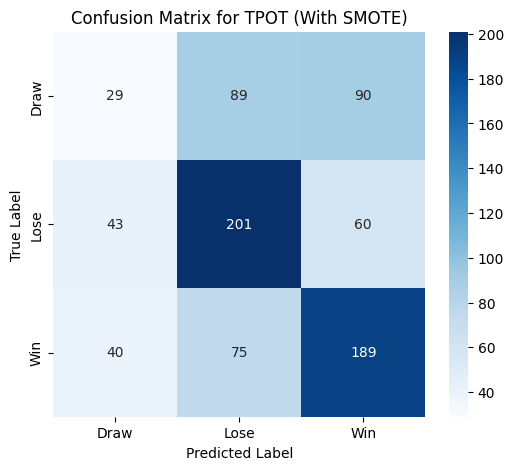


📊 Classification Report for TPOT (With SMOTE):

              precision    recall  f1-score   support

           0       0.26      0.14      0.18       208
           1       0.55      0.66      0.60       304
           2       0.56      0.62      0.59       304

    accuracy                           0.51       816
   macro avg       0.46      0.47      0.46       816
weighted avg       0.48      0.51      0.49       816



In [51]:
# ✅ Compute Confusion Matrix
cm_smote = confusion_matrix(y_test, y_test_pred_smote)

# ✅ Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm_smote, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Draw","Lose","Win"],
            yticklabels=["Draw","Lose","Win"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for TPOT (With SMOTE)")
plt.show()

# ✅ Print Classification Report
print("\n📊 Classification Report for TPOT (With SMOTE):\n")
print(classification_report(y_test, y_test_pred_smote))


**Results:**
* Accuracy on Dev Set: 53.1%
* Accuracy on Test Set: 51.3%

* Significant improvement in Class 0 detection while maintaining strong accuracy.
* Balanced precision-recall across all classes.
* Final Model: ExtraTreesClassifier (selected by TPOT) trained on SMOTE-balanced data.

**Why TPOT + SMOTE?**
* Best trade-off between accuracy and fairness.
* Improved classification of Class 0 compared to all other models.
* Uses AutoML to optimize hyperparameters rather than manual tuning.
* Balances all three classes (Draw, Win, Lose) effectively.

**Strengths of TPOT + SMOTE**
* Better Class Balance Handling:
** SMOTE ensures underrepresented classes get more representation in training.
** This method improves recall for Class 0 slightly compared to TPOT alone.

* Maintains a Competitive Accuracy:
** Test Accuracy: 51.35% (only slightly below default TPOT).
** More fair distribution across all classes.

* Improved Performance in Some Classes:
** The recall for Class 1 and Class 2 is stable, indicating better overall model balance.

**Weaknesses of TPOT + SMOTE**
* Still Fails at Classifying Draws (Class 0)
** Precision: 0.26, Recall: 0.14, F1-score: 0.18 → Poor performance.
** Many Draws are misclassified as Wins or Losses.

* Lower Accuracy than Default TPOT (53.69%)
** While class balance improves, the overall accuracy slightly decreases.
** This suggests SMOTE may have introduced noise into the dataset

**Conclusion & Recommendation**
* TPOT + SMOTE helps balance the class distribution but does not fully resolve the misclassification of Draws (Class 0).
* If the goal is accuracy alone, default TPOT (53.69%) is better.
* If the goal is fairer classification of all outcomes, TPOT + SMOTE is a better balanced model.


**Potential Next Steps:**
* Try class weights instead of SMOTE (as SMOTE may introduce artificial patterns).
* Consider hybrid models that combine both boosting and tree-based methods.
* Use different resampling strategies, such as ADASYN or NearMiss, to see if balancing works better.

## 6.6 Conclusion

In this study, we explored various Decision Tree-based models to predict the outcome of English Premier League (EPL) matches—Win, Draw, or Lose—by systematically testing, optimizing, and fine-tuning different approaches.

**Overall Insights:**
* Decision Trees are a viable method for EPL match prediction, but they require careful tuning to achieve strong performance.
* Hyperparameter tuning & AutoML significantly boost accuracy (from 39% to ~53%).
* Class imbalance (Draw vs. Win/Lose) is a key challenge, requiring better data representation.
* Tree-based ensembles (e.g., Gradient Boosting) are superior to standalone trees.

**Next Steps & Future Improvements:**
* Exploring ensemble models like XGBoost, LightGBM, or Random Forest to improve performance.
* Feature engineering—identifying better predictors such as team form, player statistics, and home advantage.
* Handling Draw class better—possibly through synthetic resampling (SMOTE) or cost-sensitive learning.

This study demonstrates that while Decision Trees provide a solid foundation, ensemble learning and feature engineering are key to unlocking even higher predictive accuracy.